# HW 2.1 Latent "Purposes" in Mobile Apps [50 + 10 points]

   * Dataset and updates: https://gist.github.com/emaadmanzoor/aedddf2b69e54a9a2fd320230bbb692a
   * Contact TA: Emaad Ahmed Manzoor (emaad[at]cmu.edu)

*Please only attempt bonus point problems after completing the non-bonus questions.*

We hypothesize the existence of latent "purposes" manifested by mobile phone applications; a "purpose" may be a specific task (such as taking photographs and uploading them to the internet), and an application may have a mixture of purposes of varying strength.

Can we uncover these purposes from a dataset of Android applications?

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## Load the data [0 points]

The [dataset](http://www.mariofrank.net/andrApps/) contains ~180,000 applications from the Android app store, including each app's name, description and permissions requested. For more about Android app permissions, see [this report](http://www.pewinternet.org/2015/11/10/an-analysis-of-android-app-permissions/)).

   * Download the data and unzip it into the same folder as this notebook.
   * Rename the CSV file to "android.csv".
   * Run the cells below to load the data into the notebook.
   * Play with the data to understand what each column may mean.

In [3]:
df = pd.read_csv("android.csv", sep=",",  thousands=",")

In [4]:
df["Number of ratings"] = df["Number of ratings"].astype(int) # fix data type
df = df.drop_duplicates(subset=["App"]).reset_index(drop=True)

In [5]:
df.head(n=3)

,App,Package,Category,Description,Rating,Number of ratings,Price,Related apps,Dangerous permissions count,Safe permissions count,...,Your personal information : read Browser's history and bookmarks (D),Your personal information : read calendar events (D),Your personal information : read contact data (D),Your personal information : read sensitive log data (D),Your personal information : read user defined dictionary (D),Your personal information : retrieve system internal state (S),Your personal information : set alarm in alarm clock (S),Your personal information : write Browser's history and bookmarks (D),Your personal information : write contact data (D),Your personal information : write to user defined dictionary (S)
0,Google Maps,com.google.android.apps.maps,Travel & Local,"Download the latest release of Google Maps, an...",4.4,1438259,$0.00,"{com.jsdfproductions.ctatrackerpro, com.alk.co...",17.0,8,...,0,0,1,0,0,0,0,0,1,0
1,Snowfall Live Wallpaper,fishnoodle.snowfall_free,Personalization,Snowfall Live Wallpaper: Wintertime on your ho...,4.3,18147,$0.00,"{colfore.wallpaper.snowfree, com.tabsoft.wallp...",0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aquarium Live Wallpaper,fishnoodle.aquarium_free,Personalization,A beautiful tropical fish tank live wallpaper!...,4.1,62145,$0.00,"{com.convisual.lwp.fishometerlite, com.accessl...",0.0,0,...,0,0,0,0,0,0,0,0,0,0


Note that the permissions are tagged with a category that describes them (for example, "system tools"). This will help us interpret them later

## Apps as documents

One approach to model apps as documents is to use their "description" field directly.

A less conventional approach is to exploit the fact that the permissions an app requests as direct evidence about what it's really trying to do. Think of app purposes as "topics", and each app as a "document" where its requested permissions are "words".

### Convert each app into a "document" [2.5 points]

   * Create a new dataframe by filtering out all the columns except the permission columns.
   * Convert this dataframe into a numpy matrix (see `as_matrix()` in Pandas).
   * You should have a (180295, 173) shape numpy matrix X containing only 0s and 1s.
   
X is now your "document" or "word-frequency" matrix.

In [7]:
df_filter_permissions = df.drop(df.columns[[0,1,2,3,4,5,6,7,8,9]], axis =1)
#df_filter_permissions.head(n=3)
X = df_filter_permissions.as_matrix()
X.shape

(180295, 173)

### Downweight "stop-words" [2.5 points]

There are some permissions requested by almost all applications (like "INTERNET"), they are similar to stop-words ("the", "and", etc.) in natural language. We can downweight them by TF-IDF normalization.

   * Use the `TfidfTransformer` class in `scikit-learn` to transform X.

In [12]:
from sklearn.feature_extraction.text import TfidfTransformer
# document frequency (df) means number of documents a word appears in
tf_idf_transformer = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)
tf_idf = tf_idf_transformer.fit_transform(X)
#tf_idf[0].toarray()

### Discover "topics" [2.5 points]

   * Use the `LatentDirichletAllocation` class in `scikit-learn` to fit 10 topics to the data.
   * Use 10 max iterations, set `n_jobs=-1` to use all cores on your machine.
   * This may take around 3 minutes to run. Test on a sample first.

In [13]:
%%time
from sklearn.decomposition import LatentDirichletAllocation
num_topics = 10
lda = LatentDirichletAllocation(n_components=num_topics, max_iter=10, n_jobs=-1,learning_method='online', random_state=95865)
lda.fit(tf_idf)
#lda.components_.shape

CPU times: user 24.1 s, sys: 1.17 s, total: 25.3 s
Wall time: 2min 55s


Now each app can be viewed as a distribution over these 20 topics, and each topic is a distribution over all the permissions in the data.

### List the top 10 "words" in each topic [10 points]

Do any of the topics correspond to meaningful app "purposes"? List the ones you find meaningful below:

   * Topic #i: "your interpretation"

In [14]:
topic_word_distributions = np.array([topic_word_pseudocounts / np.sum(topic_word_pseudocounts)
                                     for topic_word_pseudocounts in lda.components_])
num_top_words = 10

print('Displaying the top %d words per topic and their probabilities within the topic...' % num_top_words)
print()
for topic_idx in range(num_topics):
    print('[Topic %d]' % topic_idx)
    sort_indices = np.argsort(topic_word_distributions[topic_idx])[::-1]
    for rank in range(num_top_words):
        word_idx = sort_indices[rank]
        print('%s: %f' % (df_filter_permissions.columns[word_idx], topic_word_distributions[topic_idx, word_idx]))
    print()

Displaying the top 10 words per topic and their probabilities within the topic...

[Topic 0]
Hardware controls : control vibrator (S): 0.238213
System tools : set wallpaper (S): 0.220815
Network communication : full Internet access (D): 0.142469
Network communication : view network state (S): 0.111176
System tools : retrieve running applications (D): 0.105884
Storage : modify/delete USB storage contents modify/delete SD card contents (D): 0.084374
Phone calls : read phone state and identity (D): 0.074856
System tools : set wallpaper size hints (S): 0.021568
Default : act as an account authenticator (S): 0.000004
Default : bind to a wallpaper (S): 0.000004

[Topic 1]
Network communication : full Internet access (D): 0.701083
Network communication : view network state (S): 0.298455
Services that cost you money : directly call phone numbers (D): 0.000003
System tools : change your UI settings (D): 0.000003
System tools : modify global animation speed (D): 0.000003
System tools : make appl

**Topic 9: as can seen from the top words, it seems like systems tools, such as google app store**

### For each topic, list the top 3 apps with the highest probability assigned to that topic [10 points]

This further helps us understand what the topics actually mean. Go back and revise your list of topic interpretations after this: what kind of apps is each topic most likely to contain?

   * Transform the TF-IDF matrix into a matrix of topic proportions for each app; each row corresponds to one app. Consider the `transform` function of the LDA model you just fit. Now your data has been reduced to a dimensionality of just 10.


   * For each column i in 0...9:
      - Sort the rows in the topic proportion matrix by column i (topic i). Consider using `np.argsort` to obtain the sorted indices. The indices correspond to the position each row should be moved to, to obtain the rows sorted in increasing order by column i.
      - Create a new "temp" column in the original dataframe with these indices.
      - Sort the original dataframe in descending order by these indices.
      - Print the names of the top 3 apps in the sorted dataframe.
      - Only print app names having more than 1000 ratings (do something like `df[df['Number of ratings']>1000]`).

In [15]:
lda_app = lda.transform(tf_idf)

In [10]:
for i in range(num_topics):
    print('[Topic %d]' % i)
    app_sort_indices = np.argsort(lda_app.T[i])
    df["sorted_idx_topic%d" % i] = app_sort_indices
    df_top_ratings = df[df['Number of ratings']>1000]
    df_top_ratings_sorted = df_top_ratings.sort_values(by= ['sorted_idx_topic%d' % i], ascending=False) 
    #display(df_top_ratings_sorted.head(3))
    print(df_top_ratings_sorted['App'].head(3))

[Topic 0]
6088                Mileage
1159       MagicLocker Main
1152    Sex Offender Search
Name: App, dtype: object
[Topic 1]
12242           VKontakte
9310              MusicFX
11090    1Password Reader
Name: App, dtype: object
[Topic 2]
1737             Meganoid
9615     World Newspapers
9614    Earthquake Alert!
Name: App, dtype: object
[Topic 3]
9376     2Player Network Music Player
15922                  Snap Photo Pro
1464                      Doodle Dash
Name: App, dtype: object
[Topic 4]
5743         Free Wallpaper2
7952                 My Mood
29127    (D-Day)TheDayBefore
Name: App, dtype: object
[Topic 5]
96927          jjanglive
13753     Battery widget
8438     Photo Safe (PS)
Name: App, dtype: object
[Topic 6]
6027    Discover Mobile
6096    The Motley Fool
9280     Voodoo Control
Name: App, dtype: object
[Topic 7]
128687        AsciiCamera
4993      Tour Translator
15729            TuneSync
Name: App, dtype: object
[Topic 8]
18756            Fieldrunners HD
18764    Ab

### Find the most probable topic for the top 10 apps with the most ratings [10 points]

   * Use the `sort_values` and `head` functions in Pandas to find the apps with the most number of ratings.
   * Extract the indices of these apps from the dataframe, we will need these later to retrieve their permissions from the topic proportions matrix you constructed earlier.
   * For each of these 10 apps, print the permissions in their most probable topic by indexing into the topic proportion matrix.

In [11]:
df_sorted = df.sort_values(by=['Number of ratings'],ascending=False)
top10_apps = df_sorted.head(10)
app_indices = top10_apps.index

In [12]:
num_top_words = 10
for app_idx in app_indices:
    print(top10_apps['App'][app_idx]) 
    topic_sort_indices = np.argsort(lda_app[app_idx])[::-1]
    topic_idx = topic_sort_indices[0]
    print('[Topic %d]' % topic_idx)
    sort_indices = np.argsort(topic_word_distributions[topic_idx])[::-1]
    for rank in range(num_top_words):
        word_idx = sort_indices[rank]
        print('%s' % df_filter_permissions.columns[word_idx])
    print()

Facebook for Android
[Topic 3]
Services that cost you money : directly call phone numbers (D)
Your personal information : read contact data (D)
Your location : fine (GPS) location (D)
Your location : coarse (network-based) location (D)
Network communication : full Internet access (D)
Hardware controls : record audio (D)
Services that cost you money : send SMS messages (D)
Phone calls : read phone state and identity (D)
Your messages : receive SMS (D)
Network communication : view network state (S)

Google Maps
[Topic 2]
Network communication : receive data from Internet (S)
System tools : prevent device from sleeping (D)
Network communication : view network state (S)
Network communication : full Internet access (D)
Phone calls : read phone state and identity (D)
System tools : automatically start at boot (S)
Hardware controls : control vibrator (S)
Your location : fine (GPS) location (D)
Storage : modify/delete USB storage contents modify/delete SD card contents (D)
Network communicatio

## Visualization

### [Bonus] Visualize the topics using pyLDAVis. [2.5 points]

See https://github.com/bmabey/pyLDAvis.

In [16]:
topic_model_data = {'topic_term_dists': topic_word_distributions, 
            'doc_topic_dists': lda_app,
            'doc_lengths': lda_app.T[0],
            'vocab': df_filter_permissions.columns.values,
            'term_frequency': X.T.sum(axis=1)}
print('Topic-Term shape: %s' % str(np.array(topic_model_data['topic_term_dists']).shape))
print('Doc-Topic shape: %s' % str(np.array(topic_model_data['doc_topic_dists']).shape))

Topic-Term shape: (10, 173)
Doc-Topic shape: (180295, 10)


In [17]:
import pyLDAvis
topics_vis_data = pyLDAvis.prepare(**topic_model_data)
pyLDAvis.display(topics_vis_data)

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


##### Visualize the document-topic proportion matrix in 2-D using t-SNE [10 points]

Does our reduced dimensional space contain any structure? Visualize the documents (in the topic-space) using t-SNE.

   * Use `TSNE` from `scikit-learn`.
   * Set the angle to 0.99 and init to 'PCA'. Try different learning rates.
   * Remember to call `fit_transform`.
   * You may plot a sample of the data (>1000 documents) instead of the full data.
   * Plot the t-SNE dimensions as a scatterplot.
   * Color each point based on its most probable topic. Make sure you include a legend.
   
Clusters in the t-SNE plot indicate groups of apps that have similar topics.

In [27]:
%%time
# your code here
from sklearn.manifold import TSNE
plot_data = lda_app[:1500]
tsne = TSNE(n_components=2, angle=0.99, init='pca', learning_rate=100)#
tsne_results = tsne.fit_transform(plot_data) #take the first 1000

CPU times: user 16.5 s, sys: 1.97 s, total: 18.5 s
Wall time: 18.8 s


In [40]:
df_tsne_topic = pd.DataFrame(plot_data)
df_tsne_topic['x-tsne'] = tsne_results[:,0]
df_tsne_topic['y-tsne'] = tsne_results[:,1]
df_tsne_topic['topic'] =None

In [41]:
for i in range(len(plot_data)):
    topic_sort = np.argsort(plot_data[i])[::-1]
    df_tsne_topic['topic'][i]= topic_sort[0]
df_tsne_topic.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,0,1,2,3,4,5,6,7,8,9,x-tsne,y-tsne,topic
0,0.018410,0.018407,0.590829,0.111976,0.018409,0.018406,0.018408,0.018408,0.018408,0.168340,32.033863,-3.191929,2
1,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,-1.447469,-14.062809,9
2,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,2.784754,-13.552629,9
3,0.022401,0.022391,0.462376,0.132848,0.022397,0.117187,0.022393,0.022393,0.022394,0.153219,30.186495,1.823570,2
4,0.034379,0.034385,0.034377,0.034377,0.448628,0.276335,0.034388,0.034378,0.034378,0.034375,-14.215281,8.328318,4


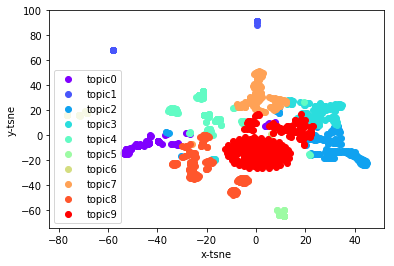

In [42]:
import matplotlib.cm as cm

topics = [i for  i in df_tsne['topic']]
x = np.arange(10)
ys = [i+x+(i*x)**2 for i in range(10)]
colors = iter(cm.rainbow(np.linspace(0, 1, len(ys))))

for (i,topic) in enumerate(set(topics)):
    xc = [x for (j,x) in enumerate(df_tsne_topic['x-tsne']) if df_tsne_topic['topic'][j]== topic]
    yc = [y for (j,y) in enumerate(df_tsne_topic['y-tsne']) if df_tsne_topic['topic'][j]== topic]
    plt.scatter(xc, yc, c=next(colors),label='topic'+str(i)) 
plt.xlabel("x-tsne")
plt.ylabel("y-tsne")
plt.legend(loc='best')
plt.show()

# Re-visualize the document-topic proportion matrix in 2-D using t-SNE [2.5 points]

   * Repeat the previous exercise, but colour the points based on their category.
   * Only plot apps in the top 10 most frequent categories.

You can now guess how your topics relate to the categories available in the app store. Some topics may correspond exactly to a specific category, while others may be a combination. Is there any topic (based on the plot above) that is very homogenous in its app categories? What is the topic and categories?

In [30]:
# find the 10 most common categories
from collections import Counter
c = Counter(df['Category'])
top10_categories = c.most_common(10)
categories = [catetory for catetory, count in top10_categories]

In [31]:
%%time
category_tsne_results = tsne.fit_transform(plot_data) #take the first 1000

CPU times: user 17.4 s, sys: 2.14 s, total: 19.5 s
Wall time: 20.4 s


In [32]:
category_df_tsne = pd.DataFrame(plot_data)
category_df_tsne['x-tsne'] = category_tsne_results[:,0]
category_df_tsne['y-tsne'] = category_tsne_results[:,1]
category_df_tsne['category'] =None

In [33]:
for i in range(len(plot_data)):
    if df["Category"][i] in categories:
        #print(df["Category"][i])
        category_df_tsne['category'][i]= df["Category"][i]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


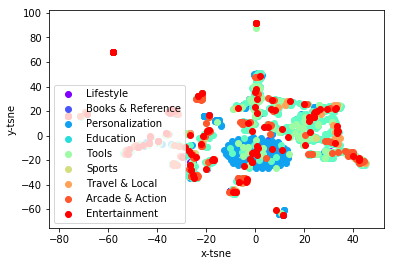

In [34]:
import matplotlib.cm as cm

categories = [cateory for cateory in category_df_tsne['category']]
x = np.arange(10)
ys = [i+x+(i*x)**2 for i in range(10)]
colors = iter(cm.rainbow(np.linspace(0, 1, len(ys))))

for (i,category) in enumerate(set(categories)):
    xc = [x for (j,x) in enumerate(category_df_tsne['x-tsne']) if category_df_tsne['category'][j]== category]
    yc = [y for (j,y) in enumerate(category_df_tsne['y-tsne']) if category_df_tsne['category'][j]== category]
    plt.scatter(xc, yc, c=next(colors),label=category) 
plt.xlabel("x-tsne")
plt.ylabel("y-tsne")
plt.legend(loc='best')
plt.show()

### [Bonus] More insights. [2.5 points]

We have only touched the surface of this dataset; many more insights remain to be uncovered. Come up with more questions and *data-driven* answers to them. Some example questions:

   - What is the relationship between topics derived from the app descriptions and topics derived from their permissions? How can they be connected and compared?
   - Is the categorization that the Android app store provides adequate? Are the topics within a category homogenous? Can you suggest an alternate categorization?

**1. Some topics may correspond to similar app descriptions. we can plot apps with app descriptions, for example we may take the top 10 kind of descriptions.    
2.From the above plot, we can see there are more tools and entertainmnet apps, but rare lifestyle apps. Some topics are correspond to the category, some are a combination. We may use packages(e.g. package name start with the same characters) as an alternate categorization.**

### [Bonus] Malware [5 points]

This dataset contains Android app permissions labelled with whether they were malware or not: https://www.kaggle.com/xwolf12/datasetandroidpermissions

Could you visually identify (using topic modeling, t-SNE or other tools) how malware applications differ from benign ones? Use both datasets (the current one, and the one from Kaggle).